# Building makemore Part 2: MLP

Youtube video link [here](https://www.youtube.com/watch?v=TCH_1BHY58I)

Paper referenced in the video, called [A Neural Probabilistic Language Model by Bengio et al.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

Makemore library reference [here](https://github.com/karpathy/makemore)

## Lecture notes



### The high-level NN architecture from the paper
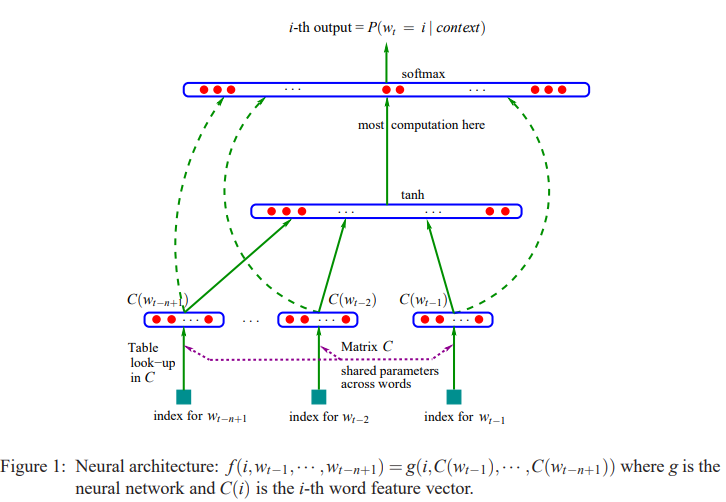ms

### Building the dataset

In [251]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import time # Ege's addition for timing the iteration speed
%matplotlib inline

In [252]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [253]:
len(words)

32033

In [254]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [255]:
# build the dataset - first 5 words as an example

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [256]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In the Bengio example, they reduce 20K words into a 30-dimensional vector space.

We want to do the same for representing our 27-char alphabet into 2-dimensional embeddings.

In [257]:
C = torch.randn((27,2))

You could technically do this via one-hot encoding using `F.one_hot` but it is more inefficient. So we are going with this approach instead.

### Pytorch indexing to speed up the process

You can use a tensor to index which is much faster. We will use this to create embeddings.

In [258]:
X[13,2]

tensor(1)

In [259]:
C[X][13,2]

tensor([-0.2782, -0.3082])

In [260]:
C[1]

tensor([-0.2782, -0.3082])

In [261]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [262]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

We want to do `emb @ W1 + b1` but it does not work due to the shape of `emb`.

In [263]:
# first get the embeddings for the word
emb[:, 0, :].shape

torch.Size([32, 2])

In [264]:
# we can use torch.cat to concatenate them
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [265]:
# we do have a torch.unbind method to unbind along a dimension
len(torch.unbind(emb, 1))

3

In [266]:
# this is the generalized version of above that becomes independent of the block size
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

#### Side content: how the internals of Pytorch work

More details on this blog post called [PyTorch Internals by Edward Z. Yang](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [267]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [268]:
a.shape

torch.Size([18])

In [269]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [270]:
# This method is super efficient due to how it is stored and how it is viewed are separate
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

Relevant bit from the blog:

![image.png](http://blog.ezyang.com/img/pytorch-internals/slide-07.png)

How is this relevant? we can use the `view` function to do the same as above, but much more efficiently

In [271]:
A = emb.view(32,6)
A.shape

torch.Size([32, 6])

In [272]:
B = torch.cat(torch.unbind(emb, 1), 1)
B.shape

torch.Size([32, 6])

In [273]:
# check that they are equivalent
# emb.view(32,6) == torch.cat(torch.unbind(emb, 1), 1).shape


# The example in the video returns False, i think it is no longer 
# found that isclose is a better check for element-wise equality
# Details: https://pytorch.org/docs/stable/generated/torch.isclose.html
torch.isclose(A, B)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

### Back to creating the hidden layer

We can use the view method to perform the weight and bias operation we wanted:

In [274]:
# using -1 makes it the actual size of emb.shape[0]
h = emb.view(-1,6) @ W1 + b1
h

tensor([[-1.3126,  1.4956,  1.0798,  ..., -1.3333,  1.5718, -2.3356],
        [-0.5992,  2.4153,  1.2973,  ..., -5.1519, -0.2676, -1.7850],
        [ 1.1525, -2.4927, -1.0917,  ..., -1.0792, -1.7912,  1.1993],
        ...,
        [ 1.9099,  0.4271, -3.5858,  ...,  1.9855, -1.4569, -7.6844],
        [ 2.7705,  0.3910, -2.6597,  ..., -3.4868, -1.4453,  0.6484],
        [-0.2910,  0.4773,  0.4888,  ..., -2.9915, -0.9477, -1.5345]])

In [275]:
h.shape

torch.Size([32, 100])

In [276]:
# Since we want this as part of our hidden layer of activation, we want to apply tanh to map these values between -1 and 1

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[-0.8649,  0.9043,  0.7931,  ..., -0.8701,  0.9173, -0.9815],
        [-0.5365,  0.9842,  0.8610,  ..., -0.9999, -0.2614, -0.9452],
        [ 0.8186, -0.9864, -0.7975,  ..., -0.7929, -0.9459,  0.8335],
        ...,
        [ 0.9571,  0.4029, -0.9985,  ...,  0.9630, -0.8970, -1.0000],
        [ 0.9922,  0.3722, -0.9903,  ..., -0.9981, -0.8948,  0.5706],
        [-0.2831,  0.4441,  0.4533,  ..., -0.9950, -0.7387, -0.9112]])

Remember to check the broadcasting is applied correctly when adding `b1` to the matrix product

* `emb @ W1` is \[32, 100]
* `b1` is \[100], which becomes \[1,100] since broadcasting is right-aligned
* Thus it applies the b1 row vector on every single one of 32 rows in emb

### Creating the output layer

In [277]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [278]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [279]:
counts = logits.exp()
counts[0]

tensor([3.7769e-02, 7.5376e-09, 2.5402e+00, 1.2709e+00, 3.0737e+03, 1.1274e-02,
        1.2943e-01, 5.8548e+02, 3.0471e+03, 1.5306e+02, 1.9947e+02, 1.0352e+02,
        2.9944e-05, 3.5931e+01, 1.5091e+04, 1.2922e+01, 4.4545e-02, 2.9354e+00,
        1.7126e+01, 1.2812e+02, 1.3088e+03, 2.9763e-08, 2.4871e-08, 4.7514e-05,
        1.4096e+00, 1.2686e-03, 1.5335e+01])

In [280]:
prob = counts / counts.sum(1, keepdims =True)
prob.shape

torch.Size([32, 27])

In [281]:
# get the prob of observing Y for each row given our current setting
prob[torch.arange(32), Y]

tensor([4.7409e-07, 8.7856e-10, 1.3999e-12, 3.6950e-12, 1.1360e-09, 5.4341e-04,
        1.5518e-14, 8.3262e-04, 4.4643e-05, 1.4924e-05, 1.8286e-09, 7.4911e-05,
        3.1697e-13, 1.6973e-16, 1.7731e-14, 3.6677e-06, 6.4366e-03, 9.9097e-01,
        1.2819e-11, 7.5859e-09, 4.2490e-09, 3.8797e-11, 3.7528e-09, 3.1231e-06,
        7.2599e-11, 5.3878e-03, 2.2851e-09, 6.4045e-19, 6.0485e-16, 9.7156e-08,
        7.5230e-08, 4.5092e-05])

In [282]:
# get the avg neg log likelihood, which is what we want to minimize
-prob[torch.arange(32), Y].log().mean()

tensor(19.0053)

### Switching to the respectable version :)


In [283]:
X.shape, Y.shape #dataset

(torch.Size([32, 3]), torch.Size([32]))

In [284]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [285]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [286]:
# current forward pass
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
# Prev:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims =True)
# loss = -prob[torch.arange(32), Y].log().mean()
# We have a faster way: cross entropy
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [287]:
for p in parameters:
    p.requires_grad = True

In [288]:
learning_rate = 0.1
# full loop
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad

17.76971435546875
13.656401634216309
11.298768997192383
9.452455520629883
7.984262466430664
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414664268493652


### With the full dataset

In [289]:
# build the dataset - first 5 words as an example

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [290]:
X.shape, Y.shape #dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [291]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [292]:
for p in parameters:
    p.requires_grad = True

In [293]:
learning_rate = 0.1
# full loop
for _ in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad

19.505229949951172
17.08448600769043
15.776532173156738
14.833343505859375
14.002608299255371
13.253263473510742
12.579920768737793
11.983104705810547
11.470495223999023
11.05185604095459


Works but is significantly slower since we now have 228k items we are passing. To alleviate that, we should use minibatches

### Minibatching

In [294]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [295]:
learning_rate = 0.1
batch_size = 32
# full loop
for _ in range(1000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

3.1174659729003906


In [296]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.6556622982025146


### How to determine a good initial learning rate

You can play around with the `learning_rate` above to see 1 is too much and 0.001 is too little. So how do we find what is "good"?

In [297]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [298]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [299]:
batch_size = 32
lri = []
lossi = []
# full loop
for i in range(1000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    learning_rate = lrs[i]
    for p in parameters:
        p.data += -learning_rate * p.grad
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
print(loss.item())

19.90939712524414
24.148481369018555
18.389625549316406
22.47460174560547
18.137069702148438
20.0776424407959
20.197153091430664
17.85015296936035
19.31864356994629
19.86772918701172
16.53362464904785
17.292131423950195
16.710573196411133
20.189273834228516
16.067028045654297
20.208189010620117
18.089950561523438
21.808258056640625
19.367565155029297
19.56258201599121
20.969575881958008
18.590240478515625
15.848454475402832
20.94541358947754
18.201173782348633
19.485645294189453
16.288734436035156
19.288307189941406
17.1114444732666
19.636043548583984
15.494185447692871
16.725566864013672
19.75766944885254
19.781827926635742
14.639065742492676
18.194650650024414
17.79381561279297
14.767807960510254
21.57497215270996
17.671735763549805
16.87747573852539
19.85218048095703
15.537503242492676
16.03949737548828
18.09499168395996
16.705982208251953
18.17633819580078
16.079559326171875
16.535093307495117
16.418376922607422
15.754687309265137
16.632095336914062
19.55653190612793
19.12052345275

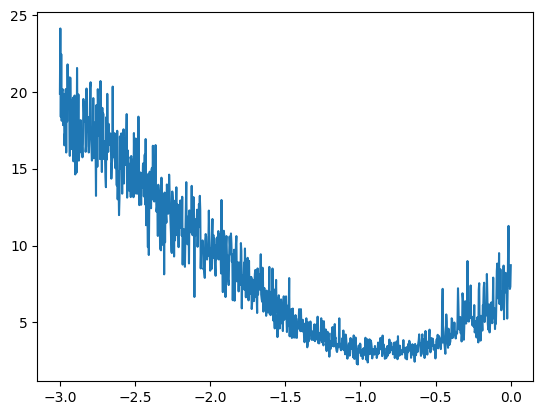

In [300]:
plt.plot(lri, lossi)

The valley here corresponds to roughly -1, which would mean that the ideal learning rate is close to 10**-1, which is 0.1.

In [301]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [302]:
learning_rate = 0.1
batch_size = 32
# full loop
for _ in range(10000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

2.7679266929626465


In [303]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.480060577392578


In [304]:
# do a learning rate decay
learning_rate = 0.01
batch_size = 32
# full loop
for _ in range(10000):
    # MINIBATCHING
    ix = torch.randint(0, X.shape[0], (batch_size,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

2.2954418659210205


In [305]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.3944568634033203


### Splitting the data into train, dev/val, test splits 

Usually 80-10-10% to avoid overfitting and optimizing hyperparameters.

In [306]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [307]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [308]:
# now use the Xtr and Ytr to train
learning_rate = 0.1
batch_size = 32
# full loop
for _ in range(10000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
print(loss.item())

2.331045150756836


In [309]:
# evaluate on Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4651241302490234


In [310]:
# compare that to Xtr and Ytr loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.469658851623535


These two losses being two close means that **we are currently underfitting the data** and that we have room to scale our NN.

### Scaling up the NN

In [311]:
# bumping up the hidden layer to 300 from 100
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [312]:
sum(p.nelement() for p in parameters) # number of parameters in total is now a lot higher

10281

In [313]:
# tracking the step number too
learning_rate = 0.1
batch_size = 32
lossi = []
stepi = []
# full loop
for i in range(30000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.1331145763397217


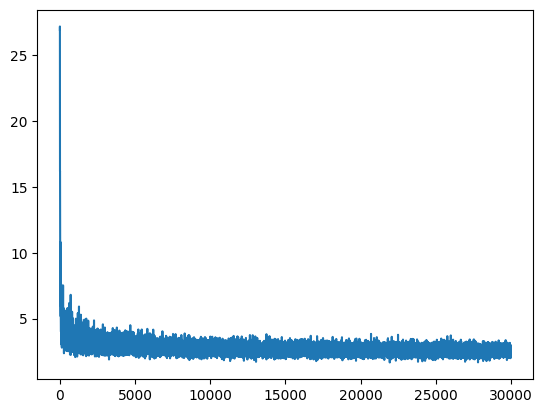

In [314]:
# show how the loss minimization is working over the training cycle
plt.plot(stepi, lossi)

In [315]:
# evaluate on Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.585874319076538


In [316]:
# compare that to Xtr and Ytr loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.590334177017212


Still way too close...

We will try changing the learning rate and running it a few more times:

In [317]:
# decrease the learning rate
learning_rate = 0.01
batch_size = 32
lossi = []
stepi = []
# full loop
for i in range(30000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.3242111206054688


In [318]:
# evaluate on Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.3080317974090576


In [319]:
# compare that to Xtr and Ytr loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.3099799156188965


### Potential Bottleneck #1 - vector space being too limiting

Maybe the two dimentional embeddings are losing too much of the fidelity?

First, let\'s visualize what we have.

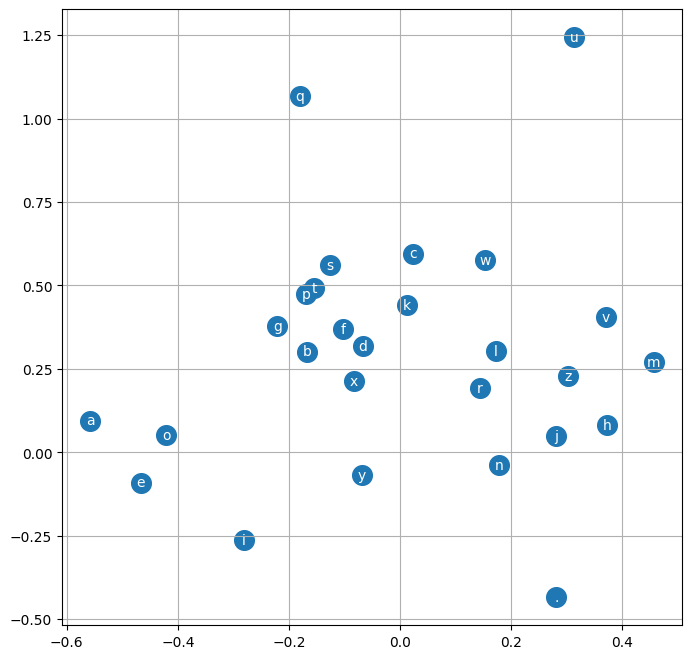

In [320]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [321]:
# bumping up the embedding size to 10 from 2
# also dropping the hidden layer size to 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [322]:
sum(p.nelement() for p in parameters) # number of parameters in total is now a lot higher

11897

In [323]:
lossi = []
stepi = []

In [324]:
# tracking the step number too
learning_rate = 0.1
batch_size = 32

# full loop
for i in range(50000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.34663462638855


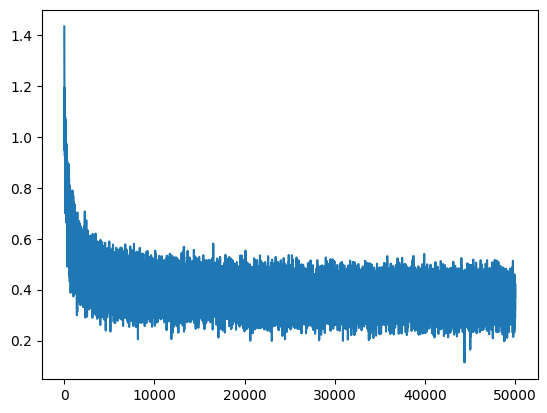

In [325]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [326]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.3321170806884766
Dev loss:  2.347221851348877


In [327]:
# now lowering the LR
learning_rate = 0.01
batch_size = 32

# full loop
for i in range(50000):
    # MINIBATCHING
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    # tracking added back
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.1822307109832764


In [328]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.181131362915039
Dev loss:  2.21059250831604


### Putting it all together

In [329]:
# bumping up the embedding size to 10 from 2
# also dropping the hidden layer size to 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [330]:
lossi = []
stepi = []

In [331]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

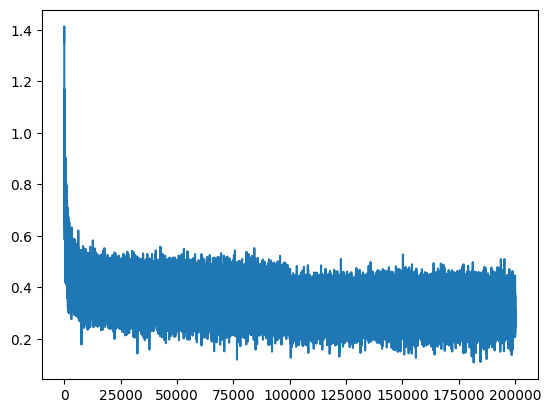

In [332]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [333]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.1241443157196045
Dev loss:  2.1612844467163086


### Bonus - sampling from the model

In [334]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seen.
nihah.
larethrushadrargelie.
edielii.
shylopaleigh.
estanar.
elle.
malaia.
noshibergahiriel.
kin.
renelipanthona.
ubdence.
ryylene.
els.
kayshaston.
azhil.
aadylynn.
azalel.


## Exercises

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [335]:
# all hyperparams
block_size = 3
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 200

### E01 - hyperparameter tuning to beat the Karpathy loss of 2.2

#### Idea #1 - change block size

In [336]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 5]) torch.Size([182580])
torch.Size([22767, 5]) torch.Size([22767])
torch.Size([22799, 5]) torch.Size([22799])


In [337]:
# make it a bit more modular with explicit hyperparams
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 200
batch_size = 32
num_iterations = 200000

In [338]:
# now plug in the numbers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, vector_dim), generator=g)
W1 = torch.randn((hidden_layer_inputs, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [339]:
sum(p.nelement() for p in parameters) # number of parameters in total is now a lot higher

15897

In [340]:
lossi = []
stepi = []

In [341]:
start = time.time()
for i in range(num_iterations):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, hidden_layer_inputs) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
end = time.time()
print("Runtime: ", end - start)
print("Loss: ", loss.item())

Runtime:  87.34132266044617
Loss:  2.058499336242676


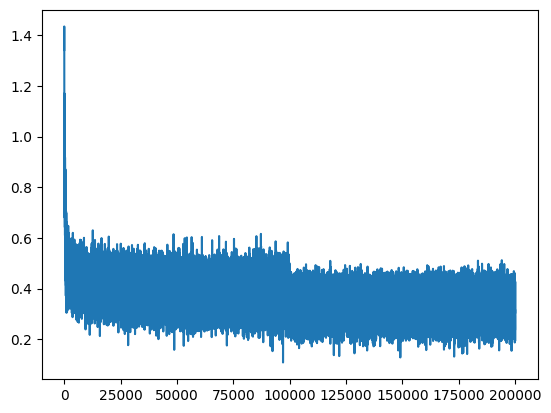

In [342]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [343]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.203059196472168
Dev loss:  2.2202961444854736


#### Idea #2 - change batch size

32 was a very random number anyway, let's update it. Keeping the increased context window for now.

In [344]:
# define the hyperparams
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 200
batch_size = 128
num_iterations = 200000

In [345]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, vector_dim), generator=g)
W1 = torch.randn((hidden_layer_inputs, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [346]:
# reset loss & step trackers
lossi = []
stepi = []

In [347]:
start = time.time()
for i in range(num_iterations):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, hidden_layer_inputs) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
end = time.time()
print("Runtime: ", end - start)
print("Loss: ", loss.item())

Runtime:  121.50154495239258
Loss:  2.0770163536071777


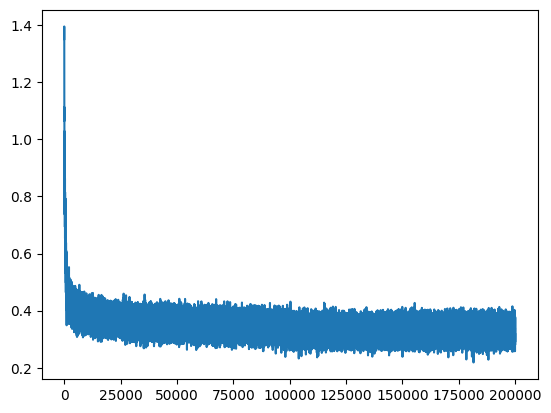

In [348]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [349]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.140131950378418
Dev loss:  2.178311347961426


We are already beating his benchmark but I want to test it further

#### Idea #3 - original block size, but larger batches, more neurons, and smoother change in learning rate

I wanted to test a mixed model of:
* bringing back the block size of 3
* updating the hidden layer to have 300 neurons
* increasing the batch size to 256
* adding a stepwise transition that starts the learning rate at 0.1 then halves it at every 50k steps (made it modular to make it easier to update)

In [350]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [353]:
# make it a bit more modular with explicit hyperparams
vector_dim = 10
hidden_layer_inputs = block_size * vector_dim #30 initially
hidden_layer_size = 300
batch_size = 256
num_iterations = 200000
decay_steps = 4

In [360]:
# reset the w&b
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, vector_dim), generator=g)
W1 = torch.randn((hidden_layer_inputs, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [361]:
# reset loss & step trackers
lossi = []
stepi = []

In [362]:
import math

start = time.time()
initial_lr = 0.1
step_points = num_iterations / decay_steps

for i in range(num_iterations):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]] 
  h = torch.tanh(emb.view(-1, hidden_layer_inputs) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  lr_update_factor = max(1, math.ceil(i / step_points))
  # update
  #lr = lrs[i]
  lr = initial_lr / lr_update_factor
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
end = time.time()
print("Runtime: ", end - start)
print("Loss: ", loss.item())

Runtime:  139.0134608745575
Loss:  1.9881294965744019


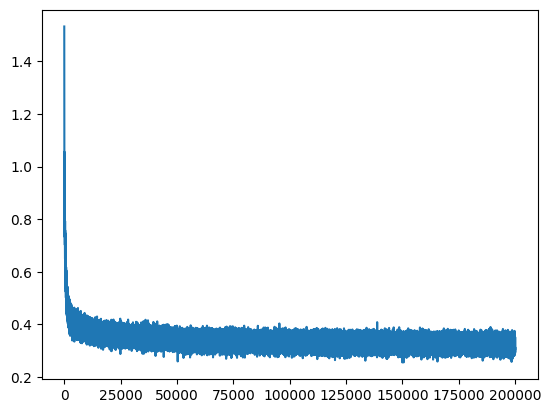

In [363]:
# now we show the log loss instead to make it look cleaner
plt.plot(stepi, lossi)

In [364]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,hidden_layer_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print("Dev loss: ", loss.item())

Training loss:  2.122040033340454
Dev loss:  2.1916983127593994


This enabled me to get batch losses below 1 and helped get the best training loss so far. 